In [1]:
!pip install emoji

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.2 MB/s eta 0:00:00


In [2]:
!pip install evaluate

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
#import evaluate
#import optuna
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
#from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
from sentence_transformers import SentenceTransformer, InputExample, LoggingHandler
import torch
from torch.utils.data import DataLoader
from transformers import Adafactor, get_linear_schedule_with_warmup
from matplotlib import pyplot as plt


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/Model for benchmark/data/train.csv')

In [6]:
data_train = data_train.drop(columns=['Unnamed: 0'])

In [ ]:
data_test = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/data_test(sp).csv')

In [8]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [9]:
data_train

,message.text,Оценка
0,Сестринское дело (1991). Перевоспитание (2020)...,2
1,"Не указано, Опыт работы: 0,5 года, Компания: К...",2
2,"Коммуникабельный, стрессоустойчивый и пунктуал...",2
3,Косметолог с опытом работы в салоне. Мне нрави...,2
4,"**Обязанности:** * Чистка лица (механическая, ...",2
...,...,...
3356,"Косметолог с 9-летним опытом, увлеченный своей...",3
3357,Косметолог с опытом работы 2.8 года. Имею высш...,6
3358,"Не указано,Стаж работы: 2.1,Компания: Здоровье...",5
3359,"По образованию фельдшер-лаборант, стаж работы ...",8


In [10]:
data_train['Оценка'].value_counts()

,count
Оценка,
4,394
1,394
8,391
2,378
6,377
0,375
7,365
3,364
5,323


In [11]:
X = data_train['message.text']
y = data_train['Оценка']
X_test = data_test['message.text']
y_test = data_test['Оценка']

In [12]:
def convert_emojis_to_words(text):

    # Convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove the : from the words and replace _ with space
    text = text.replace("_", " ")

    return text

In [13]:
symbols_pattern = re.compile(pattern = "["
    "@_!#$%^&*()<>?/\|}{~√•—"
                       "]+", flags = re.UNICODE) #спецсимволы
# двойные пробелы
space_pattern = re.compile('\s+')
#exclude = set(string.punctuation) # удаление пунктуации

In [14]:
def clear_text(text):
    """ Функция удаления спецсимволов"""
    # удаление спецсимволов и emoji
    pre = symbols_pattern.sub(r'',text)

    return space_pattern.sub(' ', pre)

In [20]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower()])
    )

    return clear_text(sentence)

In [21]:
X = X.apply(preprocess_text)

In [22]:
X_test = X_test.apply(preprocess_text)

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
model_name='intfloat/multilingual-e5-large-instruct'
model = SentenceTransformer(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

In [ ]:
class ClassificationHead(nn.Module):
  def __init__(self, embedding_dim, num_classes):
    super(ClassificationHead, self).__init__()
    self.linear = nn.Linear(embedding_dim, num_classes)
  def forward(self, data):
    x = data['sentence_embedding']
    x = self.linear(x)
    return x

num_labels = 9
classification_head = ClassificationHead(model.get_sentence_embedding_dimension(), num_labels)

In [ ]:
class SentenceTransformerplusHead(nn.Module):
  def __init__(self, transformer, classification_head):
    super(SentenceTransformerplusHead, self).__init__()
    self.transformer = transformer
    self.classification_head = classification_head
  def forward(self, input):
    data = self.transformer(input)
    logits = self.classification_head(data)
    return logits

In [ ]:
sentence_transformer_plus_head = SentenceTransformerplusHead(model, classification_head)

In [ ]:
# training parameters
num_epochs = 100
batch_size = 32
learning_rate = 1e-3


In [ ]:
# Convert the dataset to PyTorch tensors.
train_examples = [InputExample(texts=[s], label=l) for s, l in zip(X, y)]

# Customize collate_fn to convert InputExample objects into tensors.
def collate_fn(batch):
    texts = [example.texts[0] for example in batch]
    labels = torch.tensor([example.label for example in batch])
    return texts, labels

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)

# Define the loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = Adafactor(sentence_transformer_plus_head.parameters(), relative_step=False, lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
loss_list=[]
for epoch in range(num_epochs):
    sentence_transformer_plus_head.train()
    for step, (texts, labels) in enumerate(train_dataloader):
        labels = labels.to(model.device)
        optimizer.zero_grad()

        # Encode text and pass through classification head.
        inputs = model.tokenize(texts)
        input_ids = inputs['input_ids'].to(model.device)
        input_attention_mask = inputs['attention_mask'].to(model.device)
        inputs_final = {'input_ids': input_ids, 'attention_mask': input_attention_mask}

        # move model_with_head to the same device
        sentence_transformer_plus_head = sentence_transformer_plus_head.to(model.device)
        logits = sentence_transformer_plus_head(inputs_final)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if step % 500 == 0:
            print(f"Epoch {epoch}, Step {step}, Loss: {loss.item()}")

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    model_save_path = '//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/'
    model.save(model_save_path)
    loss_list.append(loss.item())

In [ ]:
# Save the final model
model_final_save_path='//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft_epoch100'
model.save(model_final_save_path)

In [26]:
y_train = np.array(y)
y_test = np.array(y_test)

In [36]:
X_train

,message.text
1662,"доброжелательная, коммуникабельная, трудолюбив..."
1988,косметолог-эстетист с опытом работы 3 года. на...
3175,"дисциплинированность, доброжелательность, обуч..."
1972,обо мне: молодая косметолог с дипломом высшего...
926,косметолог-эстетист. владею несколькими видами...
...,...
1095,"трудолюбивая, нахожу общий язык с пациентами, ..."
1130,📍 обучаю косметологов с выдачей диплома госуда...
1294,знание техник классического и лифтинг-массажа ...
860,обязанности: все должностные обязанности. орг...


In [27]:
model = SentenceTransformer('//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft_epoch100')

In [52]:
train_embeddings  = X_train.apply(lambda x: model.encode(str(x))).to_list()
val_embeddings  = X_val.apply(lambda x: model.encode(str(x))).to_list()
test_embeddings  = X_test.apply(lambda x: model.encode(str(x))).to_list()

In [46]:
evals_result={}

In [57]:
xgb1 = XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.07078025811321921, max_depth=45, n_estimators = 700, subsample=0.5458605221291573, colsample_bytree= 0.15268221810604315)
# Предсказания и оценка
xgb1.fit(train_embeddings, y_train,eval_set= [(train_embeddings, y_train), (val_embeddings, y_val)])

y_pred = xgb1.predict(test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')

[0]	validation_0-mlogloss:1.92112	validation_1-mlogloss:1.92590
[1]	validation_0-mlogloss:1.71368	validation_1-mlogloss:1.72654
[2]	validation_0-mlogloss:1.54755	validation_1-mlogloss:1.56161
[3]	validation_0-mlogloss:1.41030	validation_1-mlogloss:1.43029
[4]	validation_0-mlogloss:1.29227	validation_1-mlogloss:1.31773
[5]	validation_0-mlogloss:1.18978	validation_1-mlogloss:1.21987
[6]	validation_0-mlogloss:1.09965	validation_1-mlogloss:1.13403
[7]	validation_0-mlogloss:1.01866	validation_1-mlogloss:1.05606
[8]	validation_0-mlogloss:0.94632	validation_1-mlogloss:0.98786
[9]	validation_0-mlogloss:0.88054	validation_1-mlogloss:0.92661
[10]	validation_0-mlogloss:0.82110	validation_1-mlogloss:0.87095
[11]	validation_0-mlogloss:0.76700	validation_1-mlogloss:0.81946
[12]	validation_0-mlogloss:0.71808	validation_1-mlogloss:0.77214
[13]	validation_0-mlogloss:0.67228	validation_1-mlogloss:0.72915
[14]	validation_0-mlogloss:0.63103	validation_1-mlogloss:0.69105
[15]	validation_0-mlogloss:0.59252	

In [58]:
evals_result = xgb1.evals_result()

In [59]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred, average='weighted'))

Accuracy : 0.8558139534883721
F1 score: 0.8549905248840898


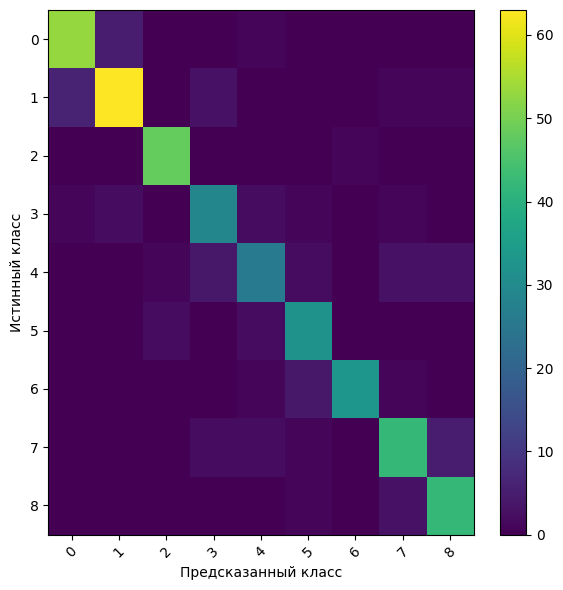

<Figure size 640x480 with 0 Axes>

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')
unique_labels = np.unique(y_test).astype(int)
ax.set_xticks(range(9))
ax.set_yticks(range(9))
ax.set_xticklabels(unique_labels, rotation=45)
ax.set_yticklabels(unique_labels)
ax.set_ylabel('Истинный класс')
ax.set_xlabel('Предсказанный класс')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()
plt.savefig('xbg_matrix.png')


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# y_true, y_pred — ваши реальные и предсказанные метки, оба одномерных np.array

# Сначала получим список всех классов
classes = np.unique(y_test)

# 1) F1-score по классам
f1_per_class = f1_score(y_test, y_pred, labels=classes, average=None, zero_division=0)

# 2) «Точность по классу» как доля правильно предсказанных среди всех примеров этого класса
#    (этот показатель в мультиклассе эквивалентен recall для данного класса)
accuracy_per_class = np.array([
    np.mean(y_pred[y_test == cls] == cls)
    for cls in classes
])

# 3) Собираем всё в DataFrame
df = pd.DataFrame({
    'class': classes.astype(str),
    'accuracy': accuracy_per_class,
    'f1_score': f1_per_class
}).set_index('class')

print(df)



       accuracy  f1_score
class                    
0      0.898305  0.890756
1      0.851351  0.875000
2      0.979592  0.960000
3      0.805556  0.783784
4      0.666667  0.712329
5      0.888889  0.831169
6      0.846154  0.904110
7      0.807692  0.815534
8      0.913043  0.865979


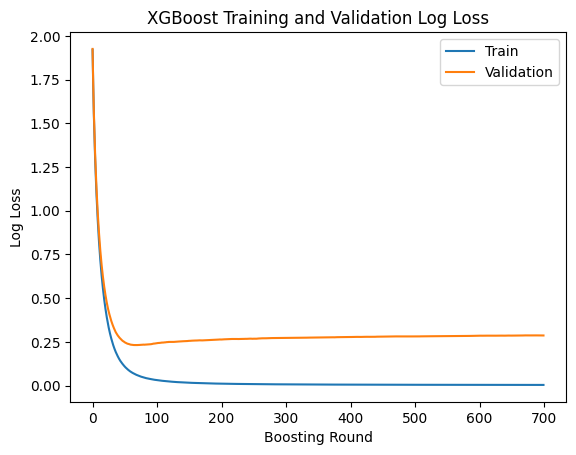

<Figure size 640x480 with 0 Axes>

In [64]:
epochs = len(evals_result['validation_0']['mlogloss'])
x_axis = range(epochs)

plt.figure()
plt.plot(x_axis, evals_result['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['mlogloss'], label='Validation')
plt.legend()
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('XGBoost Training and Validation Log Loss')
plt.show()
plt.savefig('xgb_loss.png')

In [ ]:
class Preprocessing:
    def __init__(self):
        """
        :param text: исходная строка для предварительной обработки
        """
        pass
    def fit(self, text,y=None):
      return self

    def make_string(self,text):
        """
        Приводит текст к строке, удаляет лишние пробелы и приводит к нижнему регистру
        """
        return str(text).strip().lower()

    def convert_emojis_to_words(self, text=None):
        """
        Преобразует emojis в слова
        :param text: текст для обработки; если None, используется self.text
        """
        t = text if text is not None else text
        # Переводим emoji в текстовый формат :emoji_name:
        text_1 = emoji.demojize(str(t), delimiters=(" ", " "))
        # Удаляем двоеточия и заменяем подчёркивания на пробелы
        text_1 = text_1.replace(':', '').replace('_', ' ')
        return text_1

    def clear_text(self, text):
        """
        Удаляет спецсимволы и нормализует пробелы
        :param text: текст для очистки
        """
        symbols_pattern = re.compile(r"[@_!#$%^&*()<>?/\\|}{~√•—]+", flags=re.UNICODE)
        space_pattern = re.compile(r"\s+")
        # Удаляем спецсимволы
        pre = symbols_pattern.sub('', text)
        # Нормализуем пробелы
        return space_pattern.sub(' ', pre).strip()

    def transform(self,text):
        """
        Полная предварительная обработка текста:
        - stringify + lower
        - convert emojis
        - clear text
        :returns: обработанная строка
        """
        s = self.make_string(text)
        s = self.convert_emojis_to_words(s)
        s = self.clear_text(s)
        return s



In [ ]:
class Get_embeddings:
  def __init__(self):
    self.model = SentenceTransformer('//content/drive/MyDrive/finetuning_sentance_transformer_plus_head/st_ft_epoch100')
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    train_embeddings  = list(model.encode(X))
    return train_embeddings

In [ ]:
xgb1 =XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", learning_rate=0.07078025811321921, max_depth=45, n_estimators = 700, subsample=0.5458605221291573, colsample_bytree= 0.15268221810604315)

In [ ]:
with open('xgb_model.pkl', 'wb') as output:
    pickle.dump(pipe, output)

In [ ]:
from sklearn.pipeline import Pipeline
import pickle

In [ ]:
pipe = Pipeline([('get_embeddings', Get_embeddings()),
                 ('xgb', xgb1)])

In [ ]:
pipe.fit(X, y)

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# Десериализуем pipeline из файла
with open('xgb_model.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)

In [ ]:
pred = loaded_pipe.predict(X_test)

In [ ]:
print("Accuracy :", accuracy_score(y_test, pred))
print("F1 score:",f1_score(y_test, pred, average='weighted'))